- 튜플이 삽입, 삭제 및 업데이트되는 방법을 설명.
- 튜플을 삽입하고 업데이트하는 데 사용되는 FSM(Free Space Map)에 대해 간략하게 설명.

- 튜플에 집중하기 위해 다음에서는 페이지 헤더와 라인 포인터를 표시하지 않음

**Representation of tuples.**

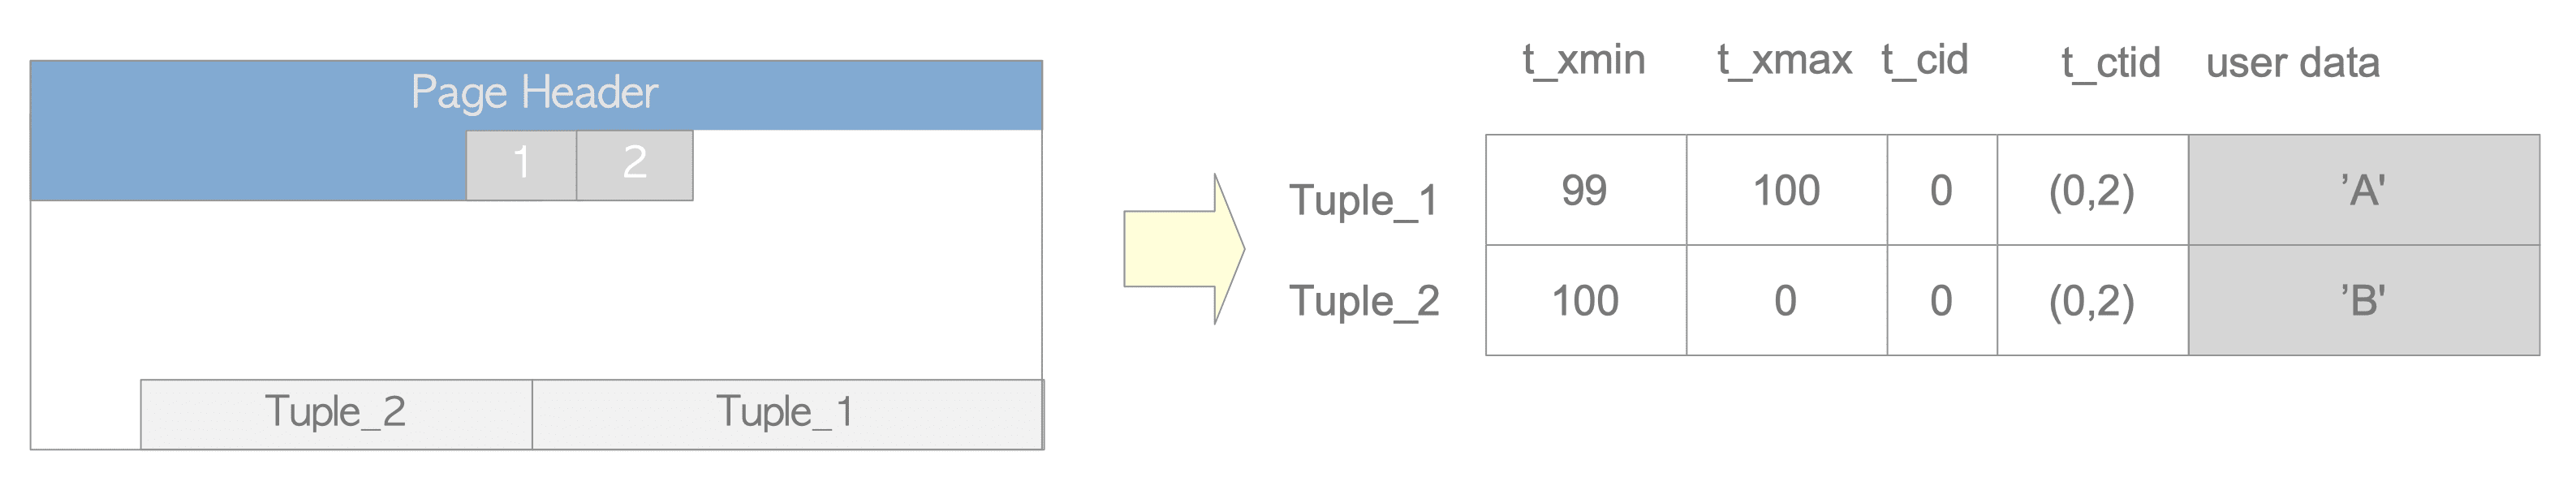

**Insertion**

- 삽입 작업을 통해 새 튜플이 대상 테이블의 페이지에 직접 삽입

**Tuple insertion.**

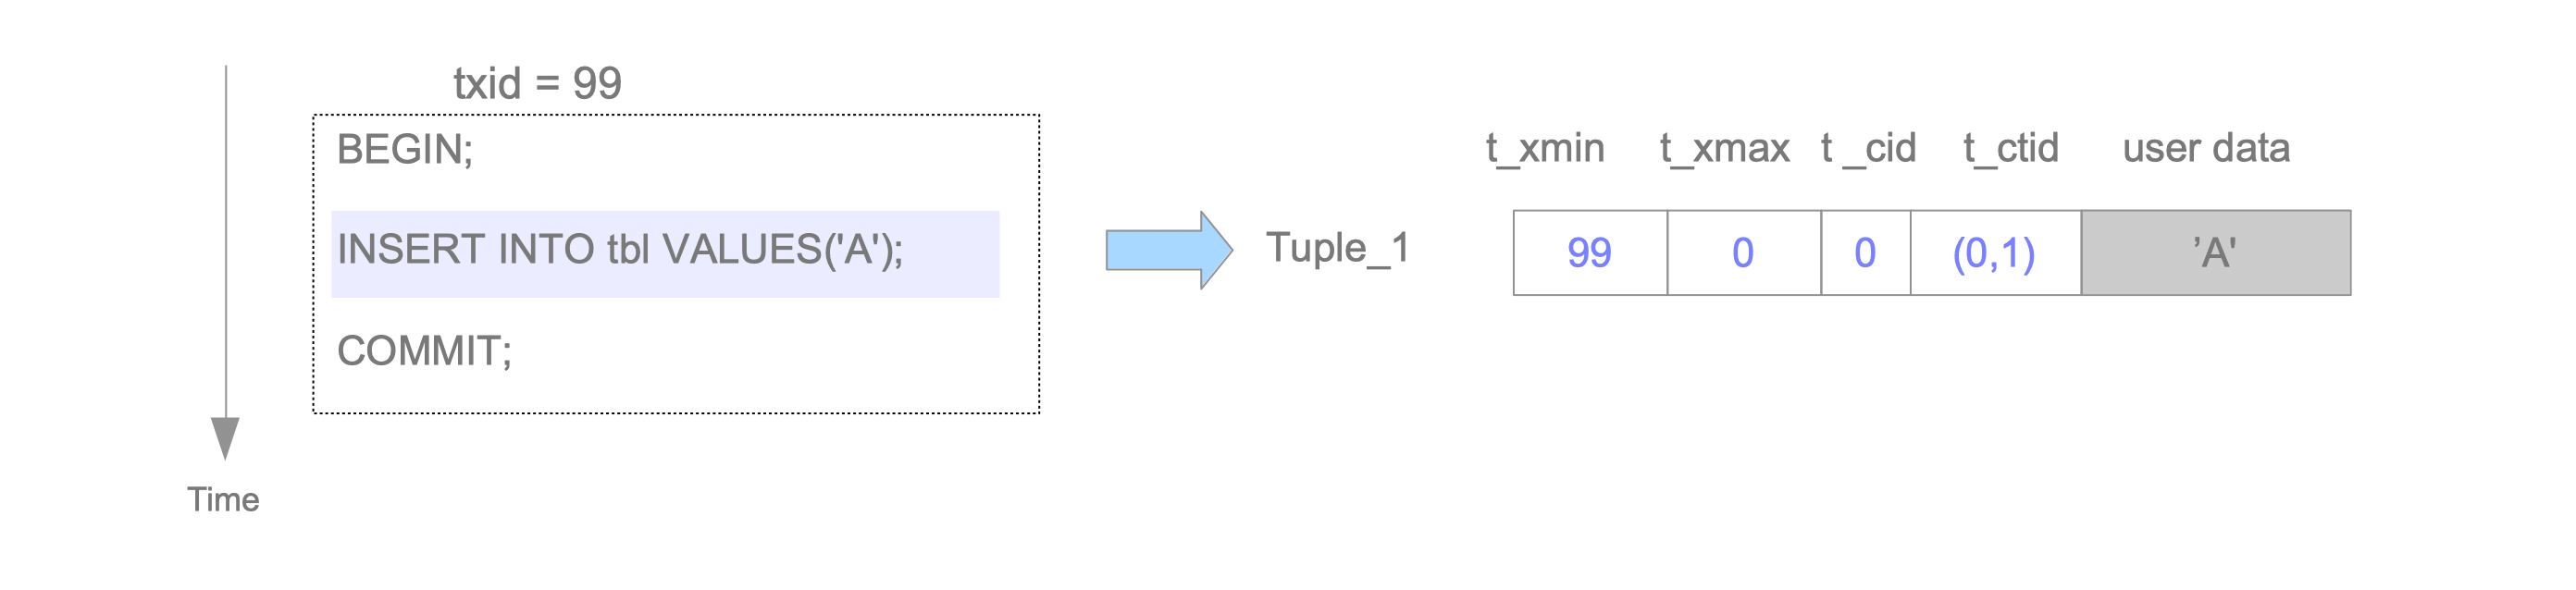

- txid가 99인 트랜잭션에 의해 페이지에 튜플이 삽입되었다고 가정.
  - 이 경우 삽입된 튜플의 헤더 필드는 다음과 같이 설정.

**Tuple_1:**
- 이 튜플은 txid 99에 의해 삽입되므로 t_xmin은 99로 설정.
- 이 튜플이 삭제되거나 업데이트되지 않았기 때문에 t_xmax는 0으로 설정.
- t_cid는 0으로 설정. 왜냐하면 이 튜플은 txid 99에 의해 삽입된 첫 번째 튜플이기 때문.
- t_ctid는 (0,1)로 설정되어 있으며 이는 최신 튜플이기 때문에 자신을 가리킴.

**페이지 검사**

- PostgreSQL은 데이터베이스 페이지의 내용을 표시하기 위해 기여 모듈인 'pageinspect' 확장을 제공.




```
testdb=# CREATE EXTENSION pageinspect;
CREATE EXTENSION
testdb=# CREATE TABLE tbl (data text);
CREATE TABLE
testdb=# INSERT INTO tbl VALUES('A');
INSERT 0 1
testdb=# SELECT lp as tuple, t_xmin, t_xmax, t_field3 as t_cid, t_ctid
                FROM heap_page_items(get_raw_page('tbl', 0));
 tuple | t_xmin | t_xmax | t_cid | t_ctid
-------+--------+--------+-------+--------
     1 |     99 |      0 |     0 | (0,1)
(1 row)
```

**Deletion**

- 삭제 작업에서는 대상 튜플이 논리적으로 삭제.
- DELETE 명령을 실행하는 txid 값은 튜플의 t_xmax로 설정



**Tuple deletion.**

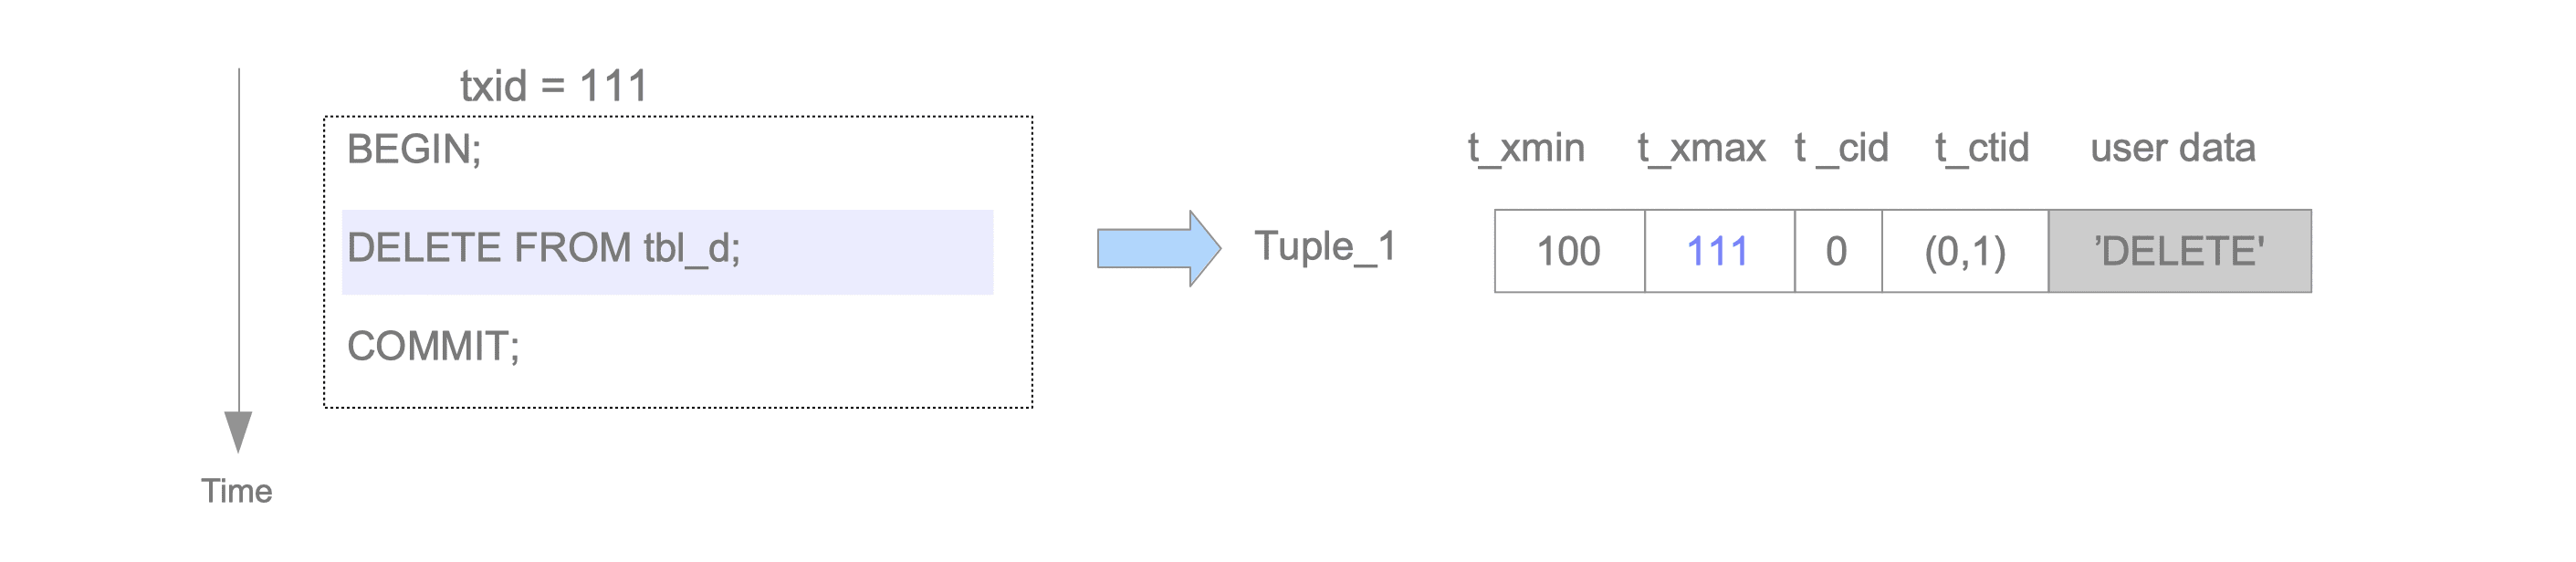

- Tuple_1이 txid 111에 의해 삭제되었다고 가정
  - 이 경우 Tuple_1의 헤더 필드는 다음과 같이 설정.

**Tuple_1:**
  - t_xmax는 111로 설정.

- txid 111이 커밋되면 Tuple_1은 더 이상 필요하지 않음.
- 일반적으로 PostgreSQL에서는 불필요한 튜플을 데드 튜플 이라고 함.

- 데드 튜플은 결국 페이지에서 제거되어야 함.
- 데드 튜플 정리를 VACUUM 처리함

**Update**

- 업데이트 작업에서 PostgreSQL은 논리적으로 최신 튜플을 삭제하고 새 튜플을 삽입

**Update the row twice.**

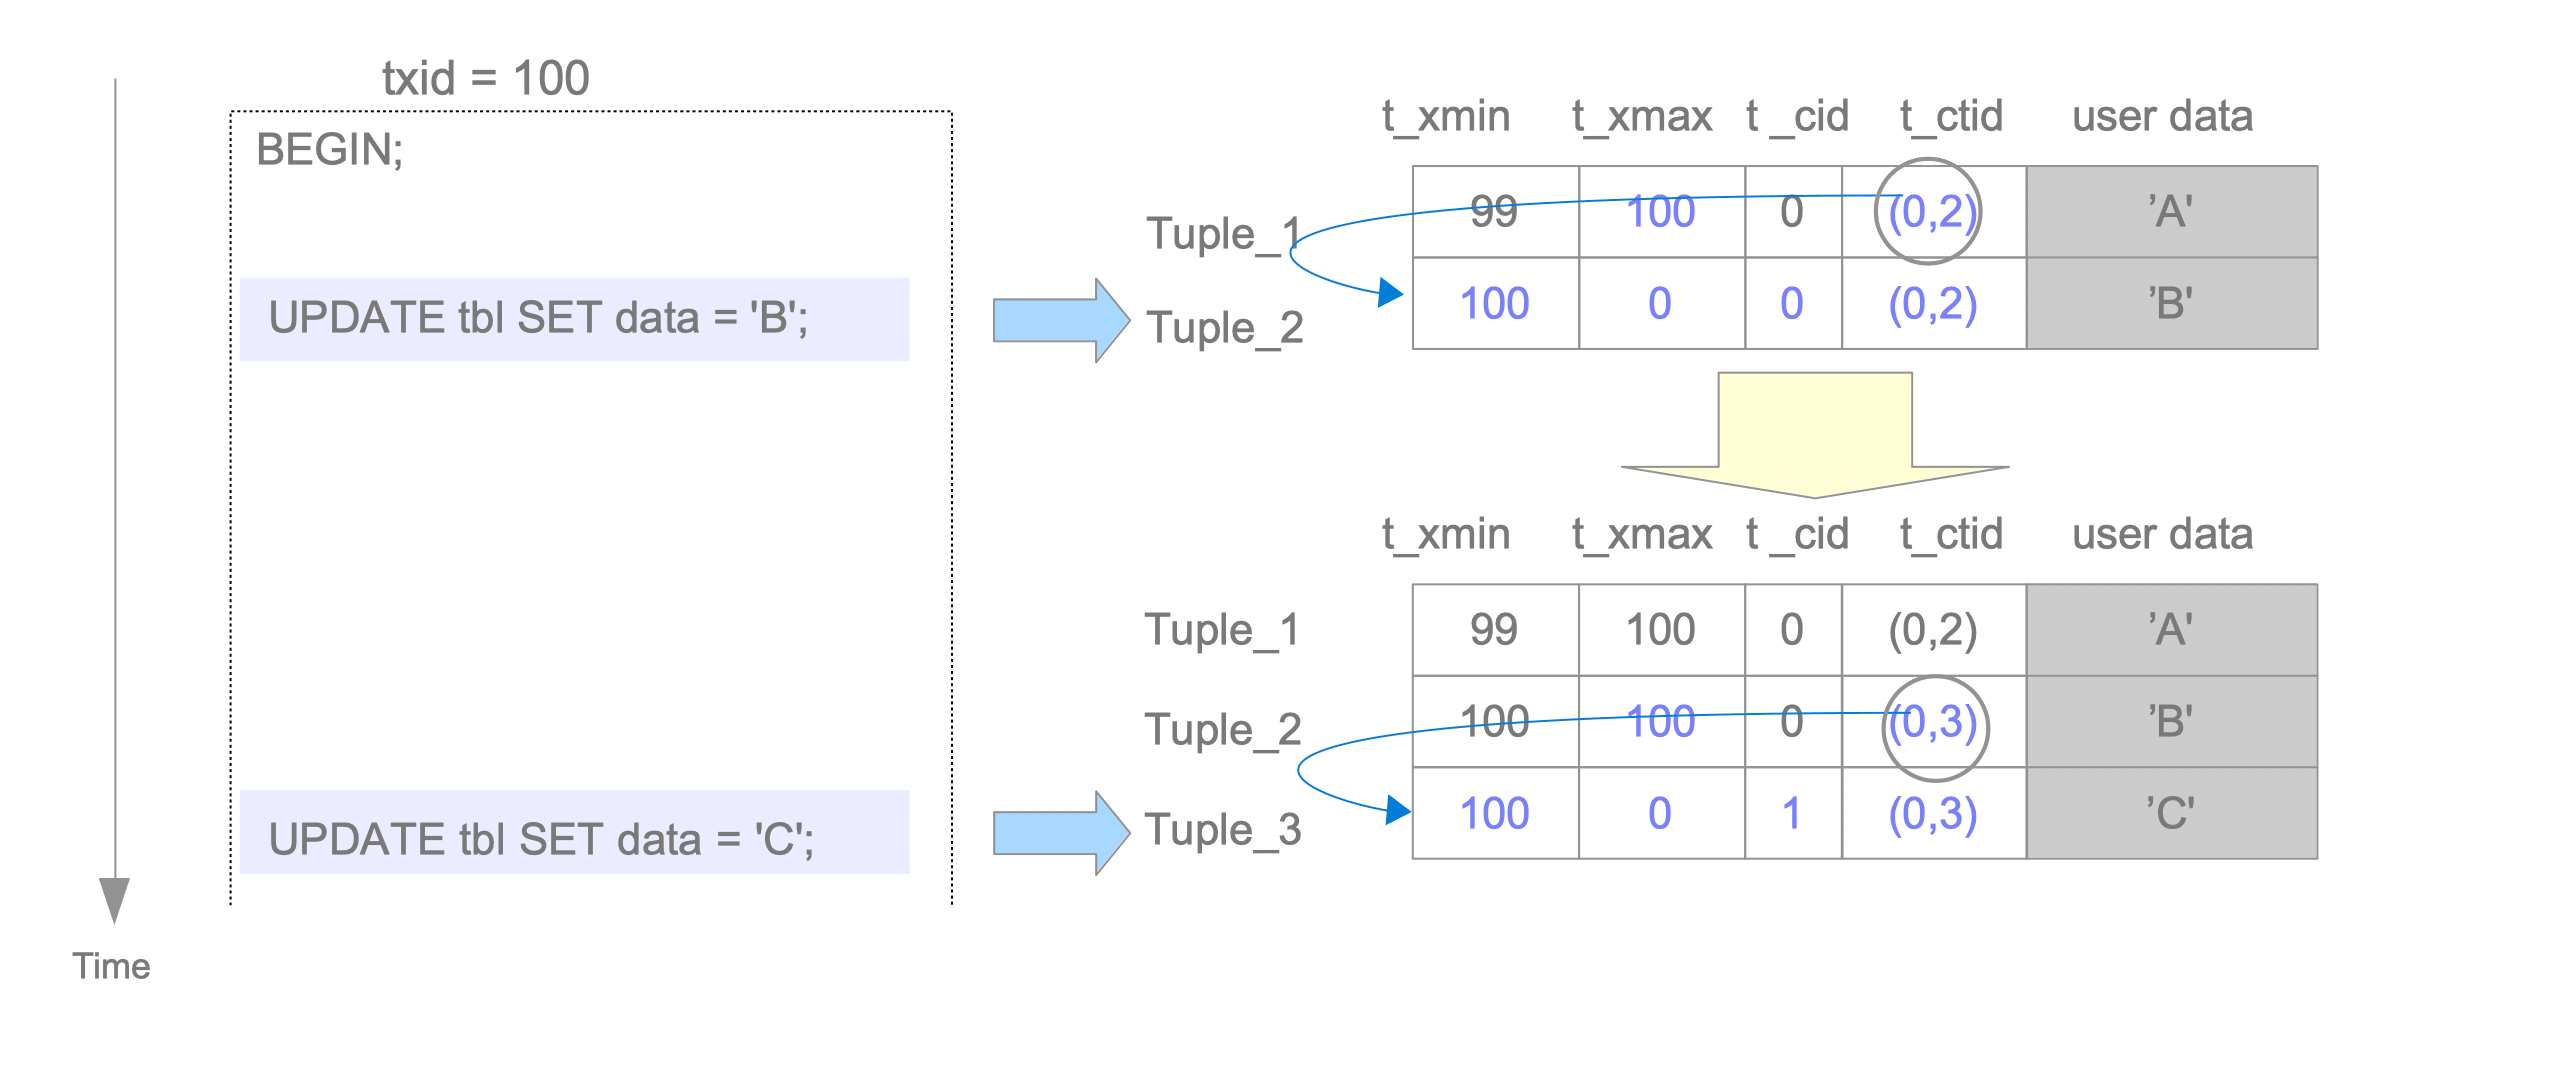

- txid 99에 의해 삽입된 행이 txid 100에 의해 두 번 업데이트되었다고 가정.

- 첫 번째 UPDATE 명령이 실행되면 txid 100을 t_xmax로 설정하여 Tuple_1을 논리적으로 삭제한 후 Tuple_2를 삽입.
- 그런 다음 Tuple_1의 t_ctid가 Tuple_2를 가리키도록 다시 작성.
- Tuple_1과 Tuple_2의 헤더 필드는 다음과 같음.

**Tuple_1:**

- t_xmax는 100으로 설정.
- t_ctid는 (0, 1)에서 (0, 2)로 다시 작성.

**Tuple_2:**

- t_xmin은 100으로 설정.
- t_xmax는 0으로 설정.
- t_cid는 0으로 설정.
- t_ctid는 (0,2)로 설정.

<br>

- 두 번째 UPDATE 명령이 실행되면 첫 번째 UPDATE 명령과 마찬가지로 Tuple_2가 논리적으로 삭제되고 Tuple_3이 삽입.
- Tuple_2와 Tuple_3의 헤더 필드는 다음과 같음.

**Tuple_2:**

- t_xmax는 100으로 설정.
- t_ctid는 (0, 2)에서 (0, 3)으로 다시 작성.

**Tuple_3:**

- t_xmin은 100으로 설정.
- t_xmax는 0으로 설정.
- t_cid는 1로 설정.
- t_ctid는 (0,3)으로 설정.

- 삭제 작업과 마찬가지로 txid 100이 커밋되면 Tuple_1과 Tuple_2는 데드 튜플이 되고, txid 100이 중단되면 Tuple_2와 Tuple_3은 데드 튜플이 됨.

**Free Space Map**

- 힙이나 인덱스 튜플을 삽입할 때 PostgreSQL은 해당 테이블이나 인덱스의 FSM을 사용하여 삽입할 수 있는 페이지를 선택.

- 모든 테이블과 인덱스에는 각각의 FSM이 있음.
  - 각 FSM은 해당 테이블이나 인덱스 파일 내 각 페이지의 여유 공간 용량에 대한 정보를 저장.

- 모든 FSM은 접미사 'fsm'으로 저장되며 필요한 경우 공유 메모리에 로드 됨.

**pg_freespacemap**

- pg_freespacemap 확장은 지정된 테이블/인덱스의 여유 공간을 제공.
- 다음 쿼리는 지정된 테이블에 있는 각 페이지의 여유 공간 비율을 보여줌.



```
testdb=# CREATE EXTENSION pg_freespacemap;
CREATE EXTENSION

testdb=# SELECT *, round(100 * avail/8192 ,2) as "freespace ratio"
                FROM pg_freespace('accounts');
 blkno | avail | freespace ratio
-------+-------+-----------------
     0 |  7904 |           96.00
     1 |  7520 |           91.00
     2 |  7136 |           87.00
     3 |  7136 |           87.00
     4 |  7136 |           87.00
     5 |  7136 |           87.00
....
```